In [1]:
# My stuff
from utils.training import DataGenerator, Engine, plot_results, make_model

# Tensorflow and Keras stuff
from keras.optimizers import Adam, Adadelta
from keras.callbacks import ModelCheckpoint
from keras import backend as K


# Modelling and Metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve,
                             f1_score, auc, average_precision_score, matthews_corrcoef, recall_score, precision_score)

# Regular stuff
import os
import numpy as np
import pandas as pd



Using TensorFlow backend.


In [20]:
#K.clear_session()
# Make our model for the cap hit predictions
model_cap = make_model(prediction_type = 'cap_hit', 
                       lstm_layers = [64, 64, 32], 
                       dense_layers= [20, 20, 20],
                       activation = 'relu')

In [3]:
# Import the data to train it with
# Note that I think here we only need the 'matched csv' for contract stats
# The other 2 contain more skaters who haven't necessarily had a standard contract yet
data_gen_cap = DataGenerator('./data/player_stats.csv',
                            './data/contract_stats_matched.csv',
                            './data/game_stats.csv',
                            prediction_type = 'cap_hit',
                            batch_size = 20)

C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
# Select an optimizer
optim = Adam()

In [22]:
# Create a training engine
engine_cap = Engine(model=model_cap, 
                    data_generator=data_gen_cap, 
                    optimizer=optim, 
                    prediction_type = 'cap_hit')

Let's have a quick look at what this model actually looks like. 

We have some time series data (every players season before their contract), 
but we also have some data that doesn't change from season to season (position, signing age, how they shoot, etc)

So we'll try a silly model: a LSTM recurrent NN that will join up with the non series data at the end. 

In [47]:
engine_cap.load_model('./models/cap_hit_model_run_noTB')

In [11]:
engine_cap.model_summary(0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 105)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 64)     43520       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 64)     33024       lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 32)           12416       lstm_2[0][0]                     
__________________________________________________________________________________________________
input_2 (I

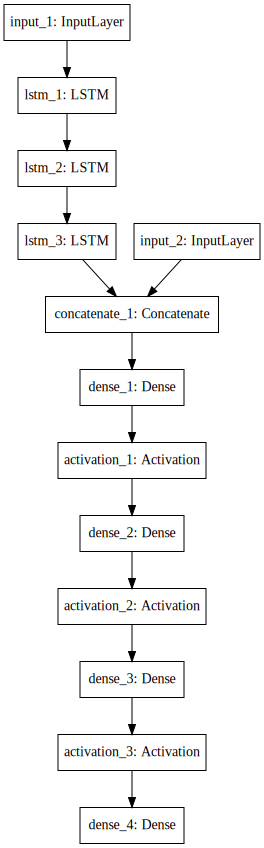

In [9]:
engine_cap.model_summary(1, './figs/cap_hit_model.png')

In [23]:
# Let's run through this once to see how we do
run_id = 'noTB'
engine_cap.fit(epochs=30, early_stopping=True, verbose=1)

Epoch 1/30
120/120 [==============================] - 17s 142ms/step - loss: 7.2708e-04 - val_loss: 3.8408e-04
Epoch 2/30
120/120 [==============================] - 12s 103ms/step - loss: 3.6382e-04 - val_loss: 3.2937e-04
Epoch 3/30
120/120 [==============================] - 13s 112ms/step - loss: 3.0841e-04 - val_loss: 3.6062e-04
Epoch 4/30
120/120 [==============================] - 16s 133ms/step - loss: 2.8622e-04 - val_loss: 2.9613e-04
Epoch 5/30
120/120 [==============================] - 14s 115ms/step - loss: 2.6190e-04 - val_loss: 3.0014e-04
Epoch 6/30
120/120 [==============================] - 14s 116ms/step - loss: 2.3997e-04 - val_loss: 2.7864e-04
Epoch 7/30
120/120 [==============================] - 14s 121ms/step - loss: 2.2503e-04 - val_loss: 2.7528e-04
Epoch 8/30
120/120 [==============================] - 14s 119ms/step - loss: 2.2760e-04 - val_loss: 2.6644e-04
Epoch 9/30
120/120 [==============================] - 15s 124ms/step - loss: 2.1716e-04 - val_loss: 2.6123e-04
E

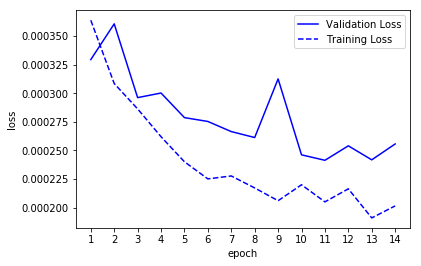

In [24]:
# Look at the loss evolution
engine_cap.plot_history(validation=True, 
                        save_file='./figs/cap_hit_losses_run_{:s}.png'.format(str(run_id)), 
                        display=True)

In [26]:
# Make a prediction for a new player
predict = engine_cap.predict(player_name='Mitchell Marner', 
                   signing_date=(4,7,2019), 
                   signing_status=1, 
                   length=7, 
                   verbose=True)

Current Cap:           81.500 M
Total Contract Value:  65.207 M
Expected Cap Hit:      9.315 M
Percentage of Cap:     11.430 %


In [27]:
# Finally, we can save the model
engine_cap.save_model('models/cap_hit_model_run_{:s}'.format(str(run_id)))

In [58]:
# Now do a bunch of runs with tensorboard on (to look at later, or in real time!), 
# save all the models 
# and get an average estimate for one player
num_models = 20
num_epochs = 50
artemi_avg = np.empty(num_models)
print('Model Prediction for Artemi Panarin: ')
for ii in range(num_models):
    K.clear_session()
    model_cap = make_model(prediction_type = 'cap_hit', 
                           lstm_layers = [64, 64, 32], 
                           dense_layers= [20, 20, 20],
                           activation = 'relu')
    
    optim = Adam()
    
    engine = Engine(model_cap, data_gen_cap, optim, prediction_type = 'cap_hit')
    
    tensorboard=True
    base_dir = 'cap_hit_logs'
    run_id = 'noTB'
    if tensorboard:
        log_dir = os.path.join('./logs', base_dir)
        run_id = len([name for name in os.listdir(log_dir)])
    engine.fit(num_epochs, tensorboard=tensorboard, early_stopping=True, verbose=0)
    engine.plot_history(True, './figs/cap_hit_losses_run_{:s}.png'.format(str(run_id)), False)
    engine.save_model('models/cap_hit_model_run_{:s}'.format(str(run_id)))
    
    predictions = engine.predict('Artemi Panarin', (4,7,2019), 1, 7, False)
    artemi_avg[ii] = predictions[0]
    
    print('Model: {:d} ** Cap Hit: {:0.3f}'.format(run_id, predictions[0]/1e6))
    
print('Salary Average: {:0.3f}'.format(np.mean(artemi_avg)/1e6))
print('Salary St Dev: {:0.3f}'.format(np.std(artemi_avg)/1e6))

Model Prediction for Artemi Panarin: 
Model: 0 ** Cap Hit: 10.802
Model: 1 ** Cap Hit: 8.942
Model: 2 ** Cap Hit: 8.315
Model: 3 ** Cap Hit: 9.530
Model: 4 ** Cap Hit: 10.828
Model: 5 ** Cap Hit: 9.216
Model: 6 ** Cap Hit: 10.046
Model: 7 ** Cap Hit: 9.102
Model: 8 ** Cap Hit: 10.362
Model: 9 ** Cap Hit: 9.734
Model: 10 ** Cap Hit: 10.342
Model: 11 ** Cap Hit: 8.747
Model: 12 ** Cap Hit: 10.149
Model: 13 ** Cap Hit: 11.794
Model: 14 ** Cap Hit: 8.989
Model: 15 ** Cap Hit: 8.676
Model: 16 ** Cap Hit: 10.433
Model: 17 ** Cap Hit: 10.863
Model: 18 ** Cap Hit: 7.239
Model: 19 ** Cap Hit: 9.173
Salary Average: 9.664
Salary St Dev: 1.045


In [15]:
# Now let's do this all but for the length of the contract 
# K.clear_session()
# Model
model_len = make_model(prediction_type = 'length', 
                       lstm_layers = [64, 64, 32], 
                       dense_layers= [20, 20, 20],
                       activation = 'relu')

# Data
data_gen_length = DataGenerator('./data/player_stats.csv',
                            './data/contract_stats_matched.csv',
                            './data/game_stats.csv',
                            prediction_type = 'length',
                           batch_size = 20)

# Optimizer
optim = Adam()

# Engine
engine_length = Engine(model_len, data_gen_length, optim, prediction_type = 'length')

C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [28]:
# Visualize 
engine_length.model_summary(0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 105)    0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, None, 64)     43520       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, None, 64)     33024       lstm_4[0][0]                     
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 32)           12416       lstm_5[0][0]                     
__________________________________________________________________________________________________
input_4 (I

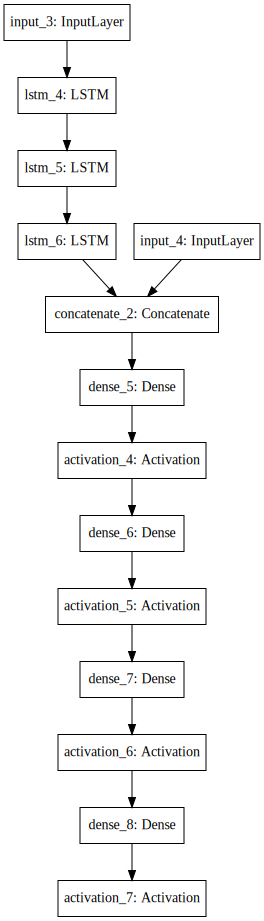

In [19]:
# Visualize
engine_length.model_summary(1, './figs/length_model.png')

In [46]:
engine_length.load_model('./models/length_model_run_noTB')

In [16]:
# Train
run_id = 'noTB'
engine_length.fit(30, early_stopping=True, verbose=1)

Epoch 1/30
120/120 [==============================] - 15s 128ms/step - loss: 1.6570 - categorical_accuracy: 0.4073 - val_loss: 1.4658 - val_categorical_accuracy: 0.4796
Epoch 2/30
120/120 [==============================] - 12s 98ms/step - loss: 1.4195 - categorical_accuracy: 0.4715 - val_loss: 1.3600 - val_categorical_accuracy: 0.4796
Epoch 3/30
120/120 [==============================] - 14s 114ms/step - loss: 1.3418 - categorical_accuracy: 0.4724 - val_loss: 1.3086 - val_categorical_accuracy: 0.4804
Epoch 4/30
120/120 [==============================] - 14s 116ms/step - loss: 1.3049 - categorical_accuracy: 0.4739 - val_loss: 1.2883 - val_categorical_accuracy: 0.4904
Epoch 5/30
120/120 [==============================] - 13s 111ms/step - loss: 1.2922 - categorical_accuracy: 0.4810 - val_loss: 1.2743 - val_categorical_accuracy: 0.4937
Epoch 6/30
120/120 [==============================] - 15s 122ms/step - loss: 1.2691 - categorical_accuracy: 0.4831 - val_loss: 1.2721 - val_categorical_accu

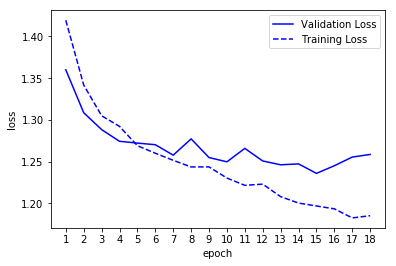

In [17]:
# Check out losses again
engine_length.plot_history(True, './figs/length_losses_run_{:s}.png'.format(str(run_id)), display=True)

In [18]:
# Predict for specific player
player_name = 'Mitchell Marner'
test = engine_length.predict(player_name, (4,7,2019), 0, verbose=True)

Length: 1 ** Probability: 0.020
Length: 2 ** Probability: 0.056
Length: 3 ** Probability: 0.025
Length: 4 ** Probability: 0.080
Length: 5 ** Probability: 0.177
Length: 6 ** Probability: 0.144
Length: 7 ** Probability: 0.046
Length: 8 ** Probability: 0.452

Most likely contract length:  8


In [25]:
# Save
engine_length.save_model('models/length_model_run_{:s}'.format(str(run_id)))

In [59]:
# Now do a bunch of runs with tensorboard on, save all the models and get an average estimate for one player
# For some reason TB doesn't work with this model. --> Fixed, it was just one of the callbacks
num_models = 20
num_epochs = 50
artemi_avg = np.empty(num_models)
print('Model Prediction for Artemi Panarin: ')
run_id = 0
for ii in range(num_models):
    K.clear_session()
    model_len = make_model(prediction_type = 'length', 
                       lstm_layers = [64, 64, 32], 
                       dense_layers= [20, 20, 20],
                       activation = 'relu')
    
    optim = Adam()
    
    engine = Engine(model_len, data_gen_length, optim, prediction_type = 'length')
    
    tensorboard=True
    base_dir = 'length_logs'
    if tensorboard:
        log_dir = os.path.join('./logs', base_dir)
        run_id = len([name for name in os.listdir(log_dir)])
    engine.fit(num_epochs, tensorboard=tensorboard, early_stopping=True, verbose=0)
    engine.plot_history(True, './figs/length_losses_run_{:s}.png'.format(str(run_id)), False)
    engine.save_model('models/length_model_run_{:s}'.format(str(run_id)))
    
    predictions = engine.predict('Artemi Panarin', (4,7,2019), 1, verbose=False)
    artemi_avg[ii] = np.argmax(predictions)+1
    
    print('Model: {:d} ** Length: {:d}'.format(run_id, np.argmax(predictions)+1))
    run_id+=1
    
print('Length Average: {:0.3f}'.format(np.mean(artemi_avg)))
print('Length Median: {:0.0f}'.format(np.median(artemi_avg)))
print('Length St Dev: {:0.3f}'.format(np.std(artemi_avg)))

Model Prediction for Artemi Panarin: 
Model: 0 ** Length: 8
Model: 1 ** Length: 8
Model: 2 ** Length: 8
Model: 3 ** Length: 8
Model: 4 ** Length: 8
Model: 5 ** Length: 8
Model: 6 ** Length: 8
Model: 7 ** Length: 5
Model: 8 ** Length: 8
Model: 9 ** Length: 8
Model: 10 ** Length: 8
Model: 11 ** Length: 8
Model: 12 ** Length: 8
Model: 13 ** Length: 8
Model: 14 ** Length: 8
Model: 15 ** Length: 8
Model: 16 ** Length: 5
Model: 17 ** Length: 8
Model: 18 ** Length: 8
Model: 19 ** Length: 8
Length Average: 7.700
Length Median: 8
Length St Dev: 0.900


In [79]:
engine_cap.load_model('./models/cap_hit_model_run_noTB')
engine_length.load_model('./models/length_model_run_noTB')

Player not found.


ValueError: If predicting from data tensors, you should specify the `steps` argument.

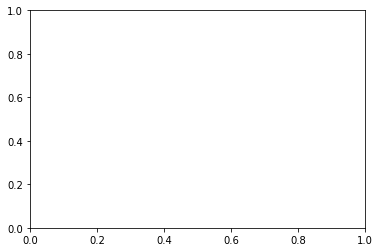

In [80]:
# Visualize Prediction Results For a Single Player
plot_results(player_name='Patrick Laine',
             signing_date=(5, 7, 2019),
             signing_status=1,
             engine_length=engine_length,
             engine_cap=engine_cap,
             save_file=False)

In [37]:
# Or use mutliple saved models to get a more statistical result
load_models = ['run_'+str(x) for x in range(20)]
load_models

['run_0',
 'run_1',
 'run_2',
 'run_3',
 'run_4',
 'run_5',
 'run_6',
 'run_7',
 'run_8',
 'run_9',
 'run_10',
 'run_11',
 'run_12',
 'run_13',
 'run_14',
 'run_15',
 'run_16',
 'run_17',
 'run_18',
 'run_19']

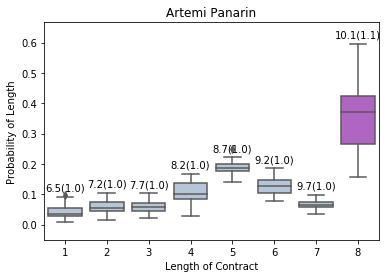

In [86]:
plot_results('Artemi Panarin', (5, 7, 2019), 1, engine_length, engine_cap, load_models = load_models)